<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/HW3_Wiskoski_Part3and4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTI-556: Computational Imaging**  
# Haley Wiskoski  
Homework #3 - Rays   
Due: Tuesday October 12, 2021  
Part 3 and 4: Projection Tomography and Coded Aperture Tomography

In [ ]:
# Python Modules
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal 
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp
from scipy import interpolate
from skimage.transform import iradon_sart
from progressbar import ProgressBar

## 3) Neural Reconstruction of Radon Data
In this exercise, we will be exploring neural reconstruction of radon data. Input images will be produced by the iradon function which reconstructs images from radon transforms (sinograms) utilizing back projection. We will examine neural reconstrution and denoising on sparsely sampled radon data and radon data with added Poisson noise. 

In [ ]:
# Loading MNIST dataset of written characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


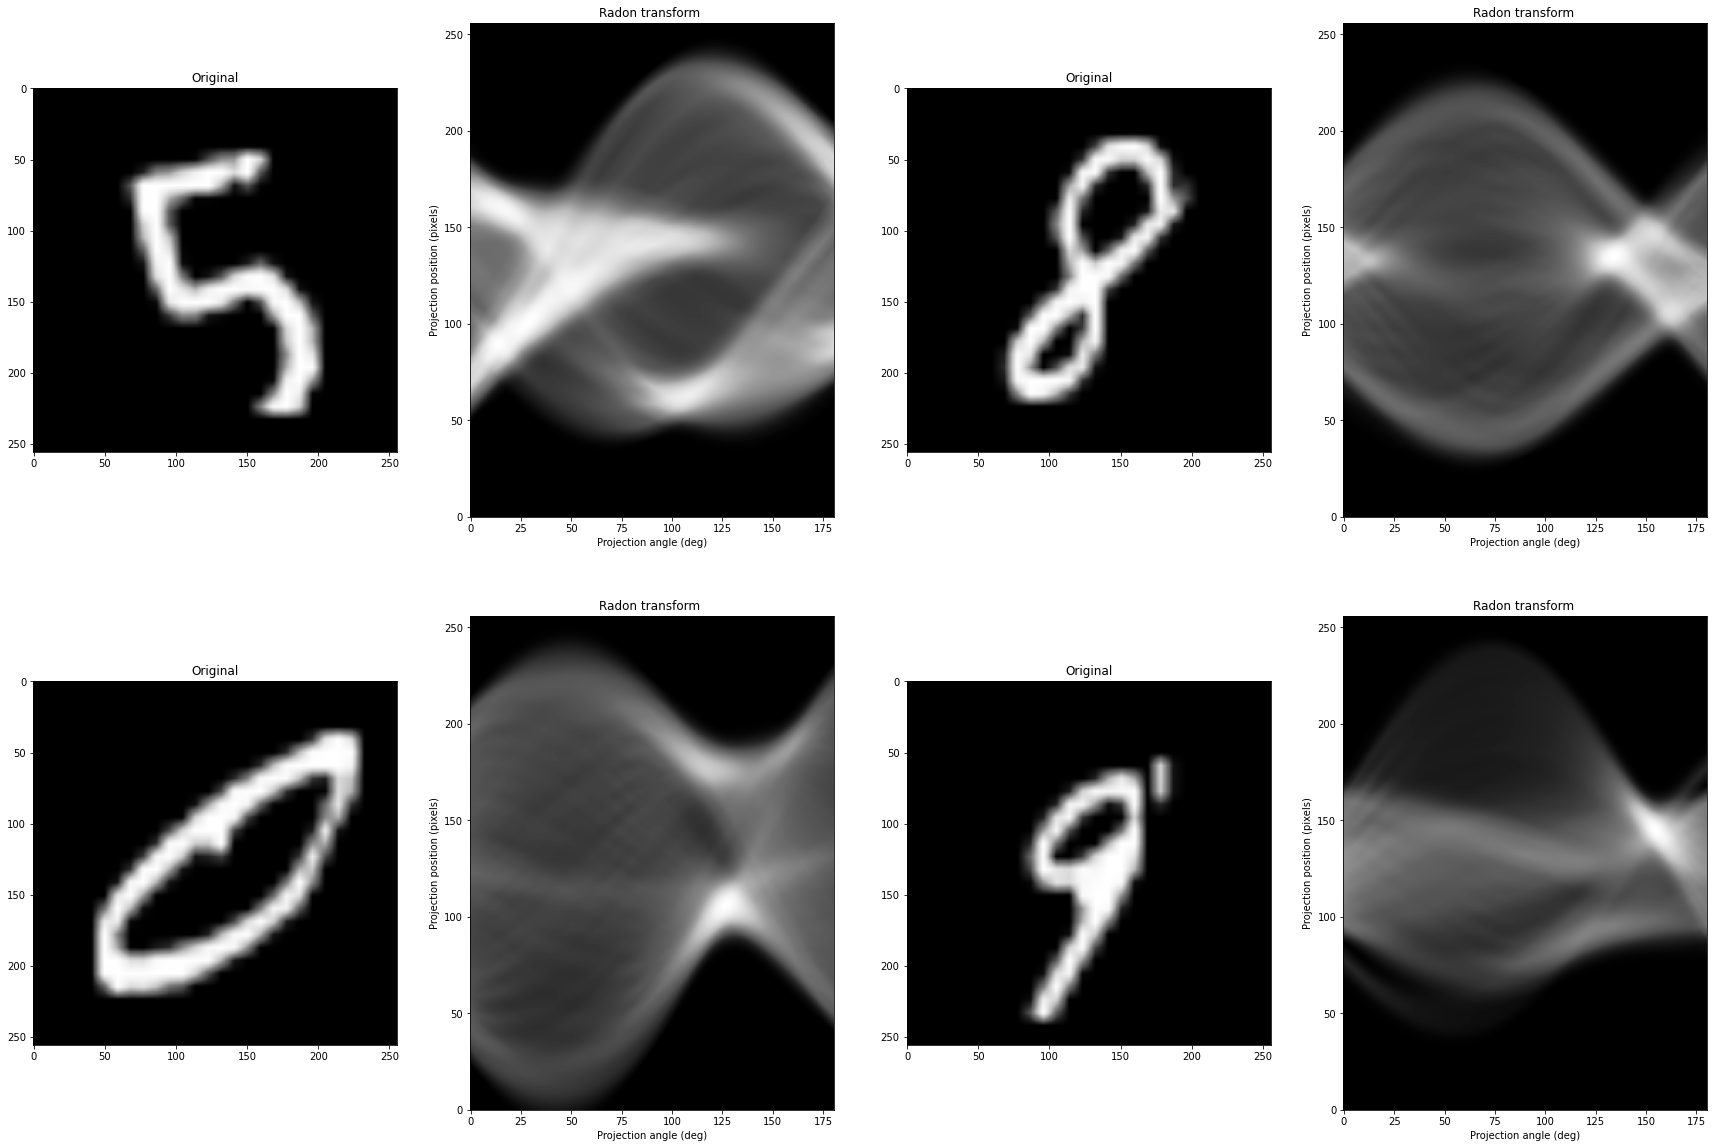

In [ ]:
# code from https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

fig, ax = plt.subplots(2, 4, figsize=(30, 20))
nP=256
image=x_train[1024,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[0,0].set_title("Original")
ax[0,0].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[0,1].set_title("Radon transform ")
ax[0,1].set_xlabel("Projection angle (deg)")
ax[0,1].set_ylabel("Projection position (pixels)")
ax[0,1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1025,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[0,2].set_title("Original")
ax[0,2].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[0,3].set_title("Radon transform ")
ax[0,3].set_xlabel("Projection angle (deg)")
ax[0,3].set_ylabel("Projection position (pixels)")
ax[0,3].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1029,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[1,0].set_title("Original")
ax[1,0].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[1,1].set_title("Radon transform ")
ax[1,1].set_xlabel("Projection angle (deg)")
ax[1,1].set_ylabel("Projection position (pixels)")
ax[1,1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')
image=x_train[1027,:,:]
image = resize(image, (nP,nP), mode='edge')
ax[1,2].set_title("Original")
ax[1,2].imshow(image, cmap=plt.cm.Greys_r)
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax[1,3].set_title("Radon transform ")
ax[1,3].set_xlabel("Projection angle (deg)")
ax[1,3].set_ylabel("Projection position (pixels)")
ax[1,3].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

### Modified iradon function

In [ ]:
from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from skimage.transform._warps import warp
from skimage.transform._radon_transform import sart_projection_update
from skimage._shared.fft import fftmodule
from skimage._shared.utils import  convert_to_float
from warnings import warn
from functools import partial

if fftmodule is np.fft:
    # fallback from scipy.fft to scipy.fftpack instead of numpy.fft
    # (fftpack preserves single precision while numpy.fft does not)
    from scipy.fftpack import fft, ifft
else:
    fft = fftmodule.fft
    ifft = fftmodule.ifft
    
def iradon(radon_image, theta=None, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True,
           preserve_range=True):
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError("Unknown interpolation: %s" % interpolation)

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError("Unknown filter: %s" % filter_name)

    radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype

    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size),
                             dtype=dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(x, col, kind=interpolation,
                                   bounds_error=False, fill_value=0)
        reconstructed += interpolant(t)

    if circle:
        out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
        reconstructed[out_reconstruction_circle] = 0.
    return reconstructed * np.pi / (2 * angles_count), projection

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)
def _get_fourier_filter(size, filter_name):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftmodule.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftmodule.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftmodule.fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftmodule.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]

### Load and Prep Data

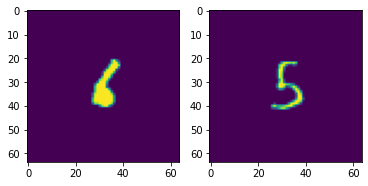

In [ ]:
# Loading MNIST dataset of written characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

plt.subplot(1,2,1)
plt.imshow(x_train[1931].reshape(64,64))
plt.subplot(1,2,2)
plt.imshow(x_test[1931].reshape(64,64))

In [ ]:
# Load previous test data in an attempt to save time in next step
x_train1 = np.load('/content/drive/MyDrive/University of Arizona/xtrain2.npy')
x_test1 = np.load('/content/drive/MyDrive/University of Arizona/xtest2.npy')

In [ ]:
# Here we're checking if the loaded data is the same as the data 
# we gathered from mnist above

# if the loaded dad from a previous session is still viable we'll load
# the rest 
if (x_train1.shape[0:3] == x_train.shape) and (x_test1.shape[0:3] == x_test.shape):
  print('Loading data from prior session...')
  g_train1 = np.load('/content/drive/MyDrive/University of Arizona/gtrain2.npy')
  g_test1 = np.load('/content/drive/MyDrive/University of Arizona/gtest2.npy')
  print('Data loaded successfully')

# if not, we will recreate the g_test and g_train data and save the new data
else:   
  ntheta = 20;
  thetaVals =np.random.choice(360,ntheta,replace=False)/2.
  g_test=np.zeros(np.shape(x_test))
  g_train=np.zeros(np.shape(x_train))

  pbar1 = ProgressBar()
  for pop in pbar1(range(np.shape(x_test)[0])):
    g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
    g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])

  pbar2 = ProgressBar()
  for pop in pbar2(range(np.shape(x_train)[0])):
    g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
    g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
  x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
  x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
  g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
  g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

  np.save('xtrain2',x_train)
  np.save('xtest2',x_test)
  np.save('gtrain2', g_train)
  np.save('gtest2', g_test)

Loading data from prior session...
Data loaded successfully


1.0


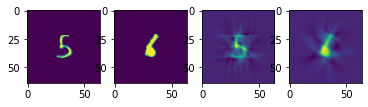

In [ ]:
if (x_train1.shape[0:3] == x_train.shape) and (x_test1.shape[0:3] == x_test.shape):
  x_train = x_train1
  x_test = x_test1
  g_train = g_train1
  g_test = g_test1

plt.subplot(1,4,1)
plt.imshow(x_test[1931].reshape(64,64))
plt.subplot(1,4,2)
plt.imshow(x_train[1931].reshape(64,64))
plt.subplot(1,4,3)
plt.imshow(g_test[1931].reshape(64, 64))
plt.subplot(1,4,4)
plt.imshow(g_train[1931].reshape(64, 64))
print(np.max(g_test[1931]))

### Denoising Model #1

In [ ]:
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 16)        4624  

In [ ]:
# Training Model #1
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 32s 33ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 9.6413e-04 - val_loss: 8.6335e-04
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 8.3949e-04 - val_loss: 7.8716e-04
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 7.6205e-04 - val_loss: 7.4898e-04
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 7.0034e-04 - val_loss: 6.4672e-04
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 6.5627e-04 - val_loss: 6.1218e-04
Epoch 8/10
469/469 [==============================] - 15s 32ms/step - loss: 6.1678e-04 - val_loss: 6.1762e-04
Epoch 9/10
469/469 [==============================] - 15s 32ms/step - loss: 5.9275e-04 - val_loss: 5.6003e-04
Epoch 10/10
469/469 [=====

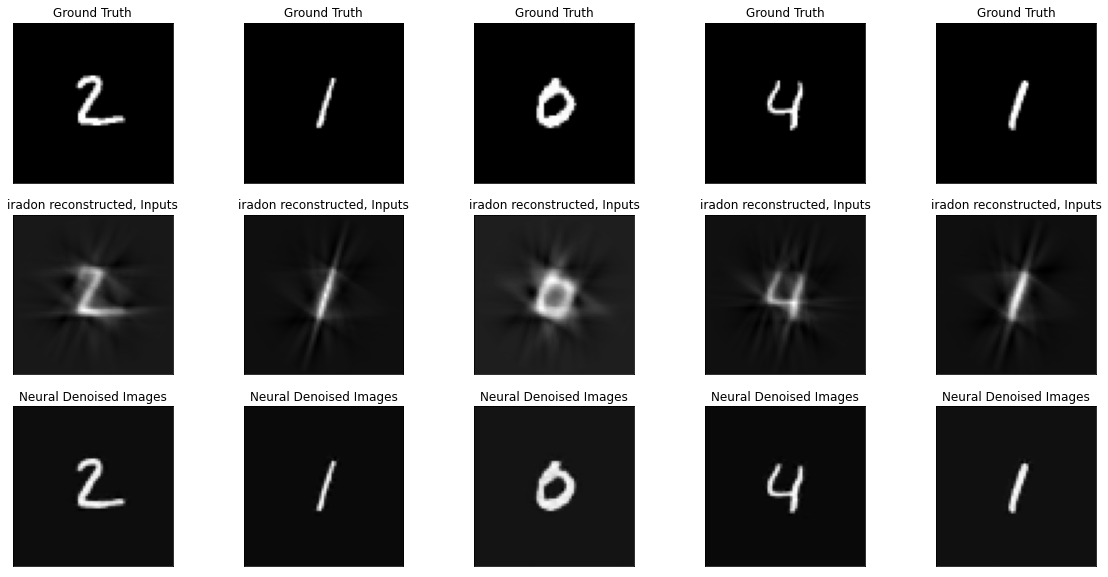

In [ ]:
# Getting our results
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.title('Ground Truth')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.title('iradon reconstructed, Inputs')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:i+1,:,:,:])[0,:,:,0])
    plt.title('Neural Denoised Images')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Denoising Model #2
Adding poisson noise to the measurements, and randomly spaced values of theta.

In [ ]:
# Load and prep data again, with noise
# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
nPhoto=1
# we are going to add poisson noise to the measurements. 
# nPhoto is an gain factor for the intensity of the measured signal

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

pbar1 = ProgressBar()
g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in pbar1(range(np.shape(x_test)[0])):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
pbar2 = ProgressBar()
for pop in pbar2(range(np.shape(x_train)[0])):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

N/A% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
100% (10000 of 10000) |##################| Elapsed Time: 0:01:54 Time:  0:01:54
100% (60000 of 60000) |##################| Elapsed Time: 0:11:30 Time:  0:11:30


In [ ]:
# Creating the Layers
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 64, 64, 16)        4624

In [ ]:
# Training the network
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 16s 33ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/10
469/469 [==============================] - 15s 32ms/step - loss: 0.003

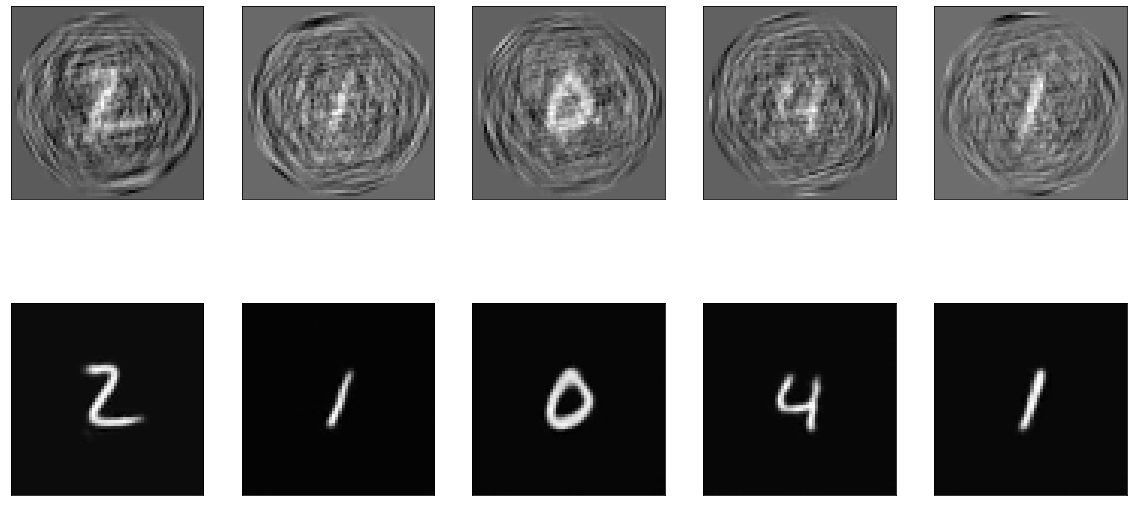

In [ ]:
# Plots and results of images
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Denoising Model #3
In this next model we take in fully sampled data with added poisson noise. We will reconstruct and denoise and finally compare the outputs. 

In [ ]:
# Load and prepare the data
from keras.datasets import mnist

ntheta=20*9;
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
nPhoto=1/9

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))

pbar1 = ProgressBar()
for pop in pbar1(range(np.shape(x_test)[0])):
  g_test[pop,:,:]= iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
pbar2 = ProgressBar()
for pop in pbar2(range(np.shape(x_train)[0])):
  g_train[pop,:,:]=iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

np.save('xtest3',x_train)
np.save('xtest3',x_test)
np.save('gtrain3', g_train)
np.save('gtest3', g_test)

N/A% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
100% (10000 of 10000) |##################| Elapsed Time: 0:16:39 Time:  0:16:39
100% (60000 of 60000) |##################| Elapsed Time: 1:39:24 Time:  1:39:24


In [ ]:
# Creating the network layers
inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

In [ ]:
# Training the model
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

In [ ]:
# Showing reconstructions and denoising results
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Discussion

For this exercise, we are comparing neural compressed sensing for several different cases. The three networks being tested here have the same layers and architecture, but we explore the results of sparsely sampled data with no added noise, with added poisson noise, and finally fully sampled data with added noise. 

For the first network with sparsely sampled data and no noise, we obtain very nicely reconstructed images with significantly reduced noise. The output images closely resemble the ground truth objects. 

With the addition of poisson noise in sparsely sampled data, the network outputs images with significantly reduced noise, but the objects aren't as clear or defined as in the previous case. They aren't distorted in any way, though. 

Finally, we perform nerual compressed sensing on fully sampled radon data with added poisson noise. This case resulted in the poorest reconstructions. Our output images, although denoised, are severely distorted and almost unrecognizable as handwritten characters. 

From these results, we can see that the presence of noise can sometimes be beneficial when reconstructing objects with a sparse amount of data. One would not assume that the sparesly sampled data would outperform the full rank data, but in this case, the presence of noise aids in the final reconstruction. These concepts are important, as in the medical field, less data typically translates to less radiation, scans, time, money, etc., so exploring how we may be able to obtain images from from limited resources is an important endeavor. 

In the past, I have played around with various backprojection algorithms and learned about the topic in classes, but I have never implemented this process in a neural network. Overall, this was a very fun and informational exercise demonstrating the results of sparesly sampleded / fully sampled data. 

## 4) Coded Aperture Tomography 
In this section we will attempt to measure a two-dimensional object space with a one-dimensional coded aperture normal to the x-direction and a one-dimensional coded aperture in the y-direction. We'll then take these results and attempt neural denoising of the images.

Our code patterns orthogonal to the x and y axes are as follows: 

$t(x) = \sum_{-P/2}^{P/2} t_p rect(x-p\Delta)$  

$t(y) = \sum_{-P/2}^{P/2} t_p rect(y-p\Delta)$  

### Forward Model

In [ ]:
# Creating the x and y code patterns 

# for x direction
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g =t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def hx(i,j):
  hx=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return hx
Hx=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    Hx[i,j]=hx(i,j)

In [ ]:
# for y-direction
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj+1
  yj=yj-N*delta/2
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[0])*p(j)[1])/(1+(l/p(j)[0])))
  return g
def hy(i,j):
  hy=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return hy
Hy=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    Hy[i,j]=hy(i,j)

Text(0.5, 1.0, 'y-Space Code Pattern')

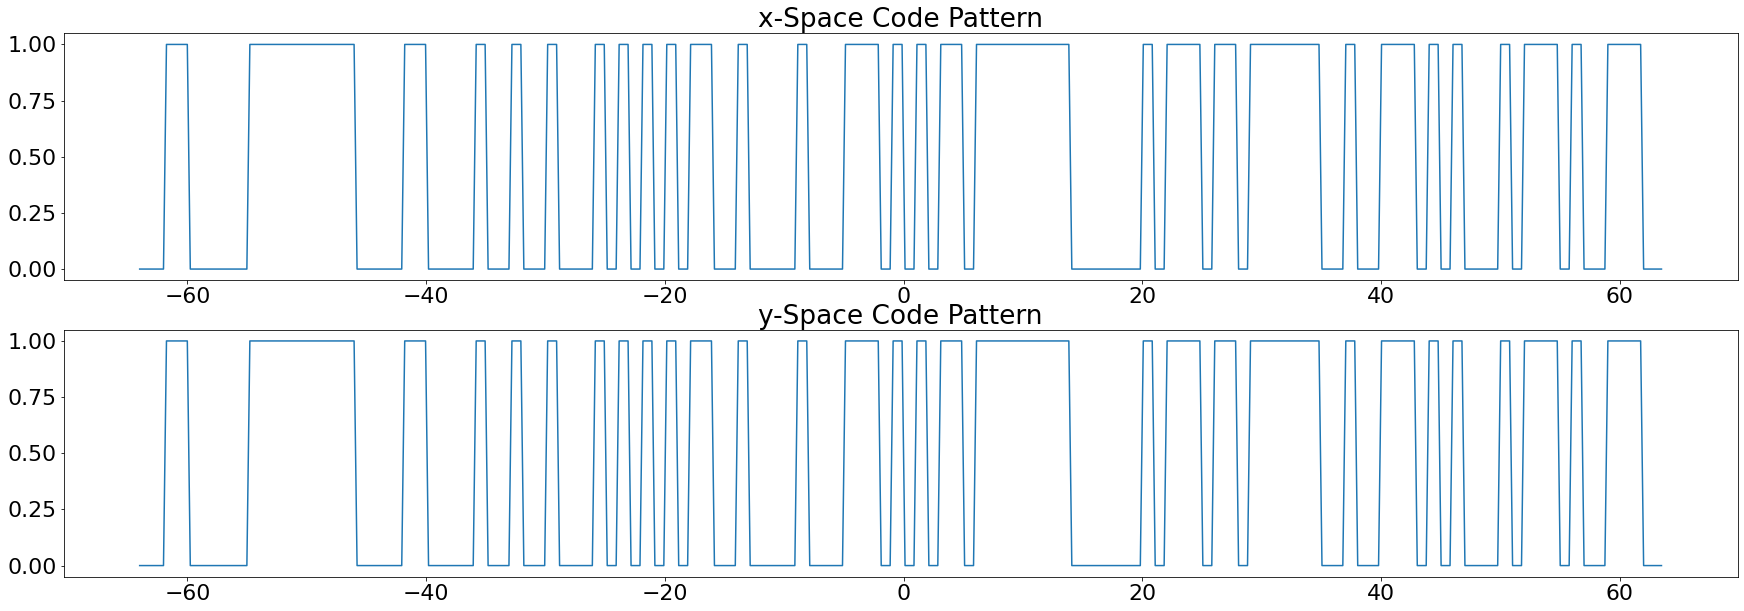

In [ ]:
# plotting what we have
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
yspace = xspace
plt.subplot(2,1,1)
plt.plot(xspace,vt(xspace))
plt.title('x-Space Code Pattern')
plt.subplot(2,1,2)
plt.plot(yspace,vt(yspace))
plt.title('y-Space Code Pattern')

Text(0.5, 1.0, 'Projections from H cols')

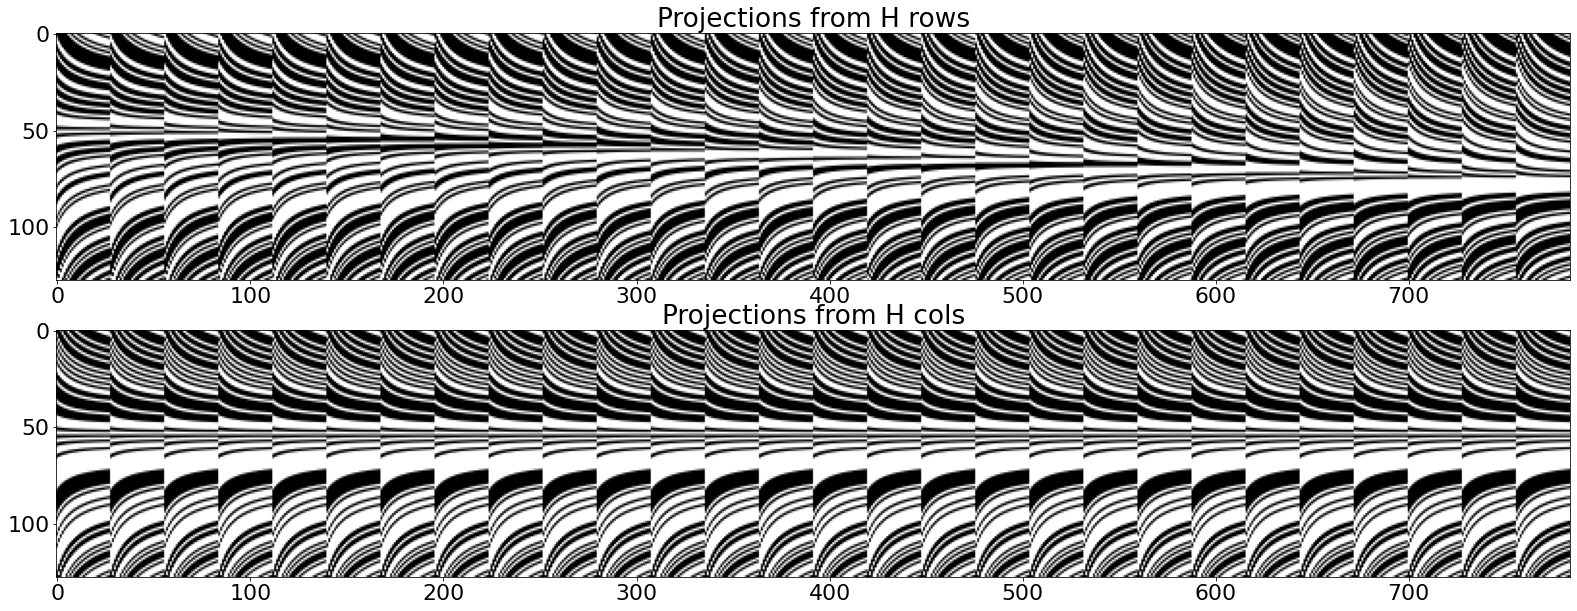

In [ ]:
# Here we visualize the projection that each row (x-direction aperture) 
# and column (y-direction aperture) of H makes on the NxN object space

plt.subplot(2,1,1)
plt.imshow(Hx)
plt.title('Projections from H rows')
plt.subplot(2,1,2)
plt.imshow(Hy)
plt.title('Projections from H cols')

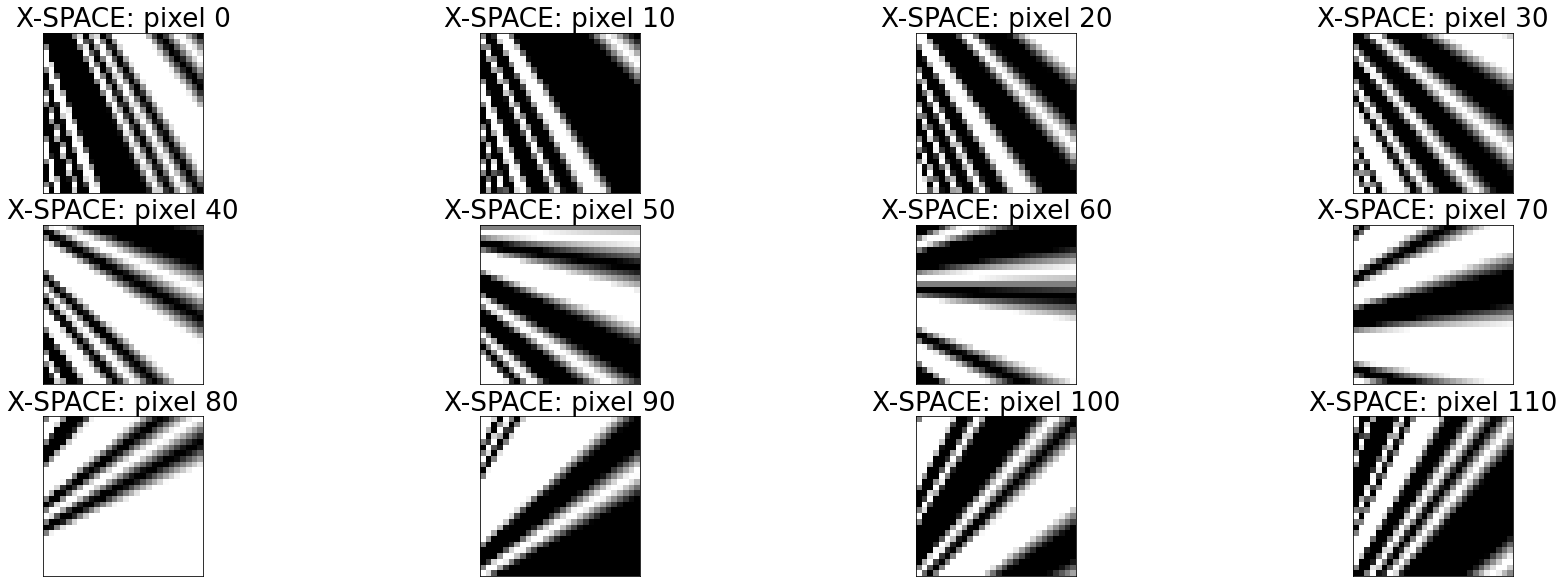

In [ ]:
# Visualizing individual pixels (x-direction)
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(Hx[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('X-SPACE: pixel '+np.str(10*i))    

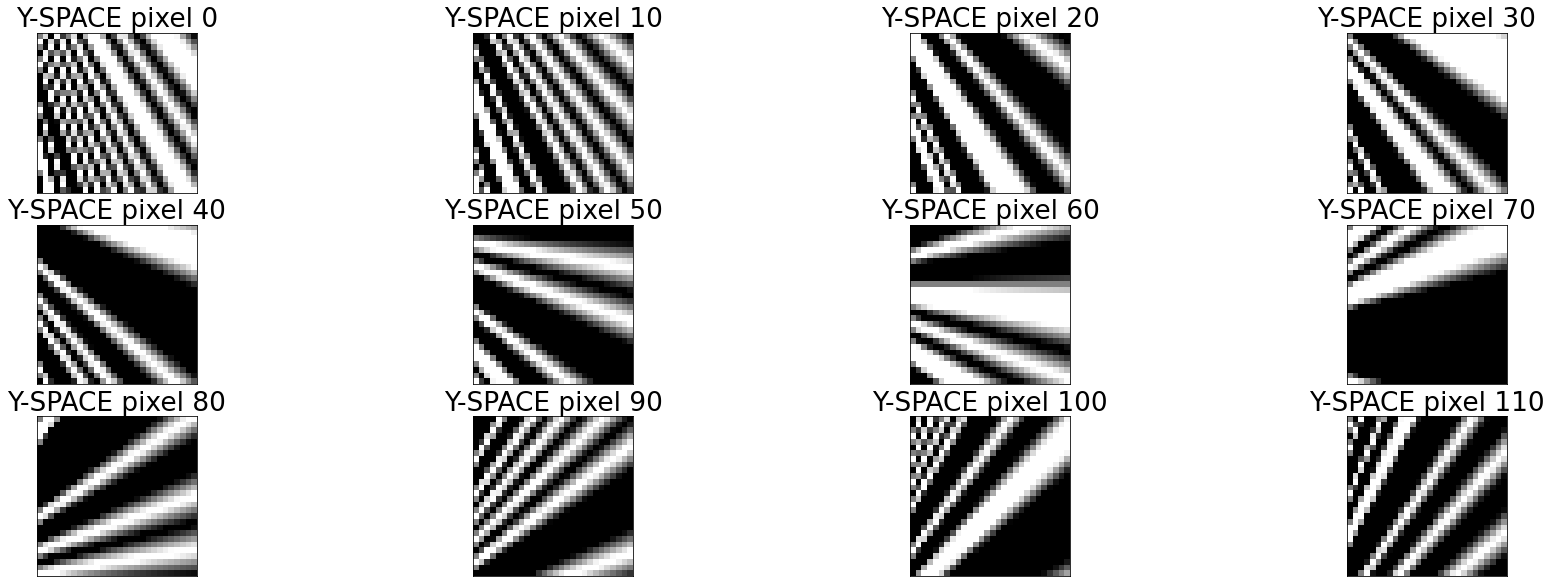

In [ ]:
# Visualizing individual pixels (y-direction)
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(Hy[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Y-SPACE pixel '+np.str(10*i))

Text(0.5, 1.0, 'y aperture')

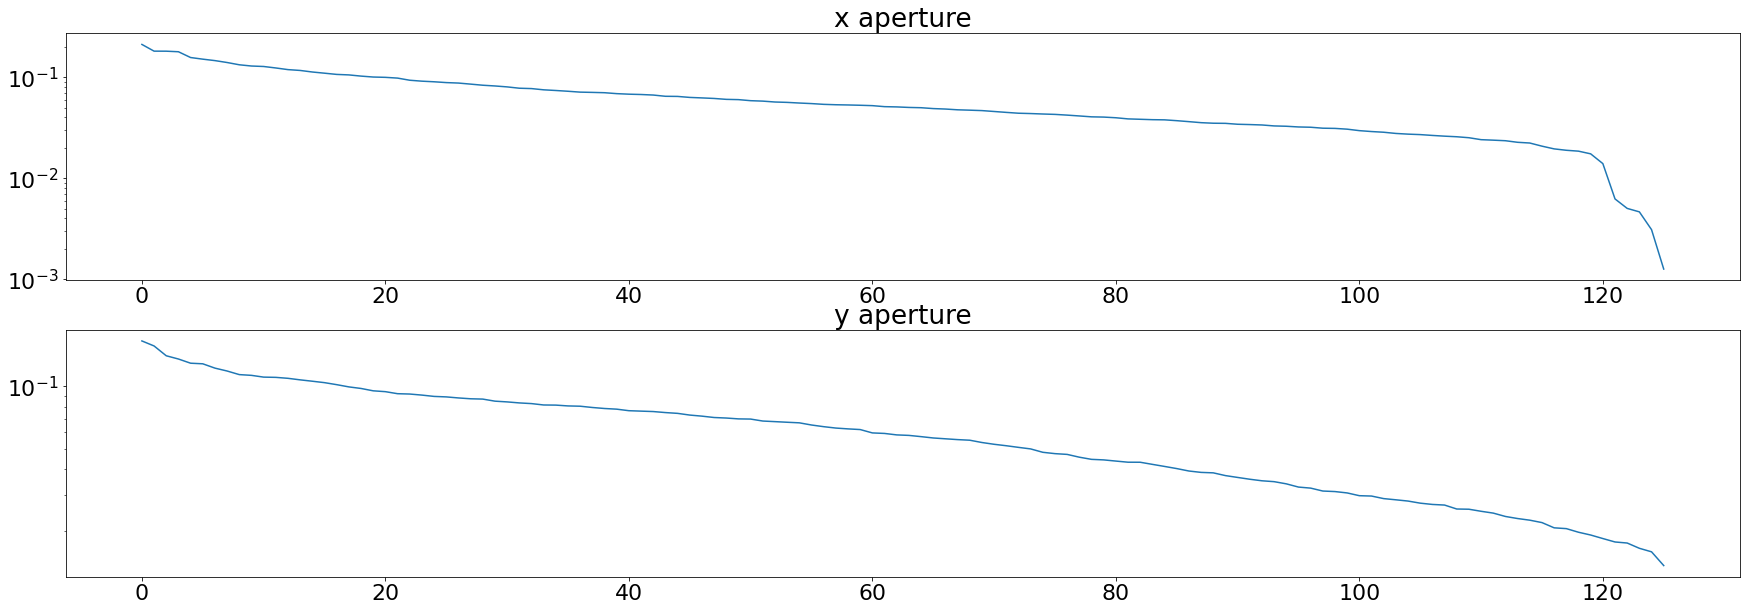

In [ ]:
#Single Value Decomposition
u_x, lam_x, vh_x = np.linalg.svd(Hx)
u_y, lam_y, vh_y = np.linalg.svd(Hy)
ph_x=np.linalg.pinv(Hx)
ph_y=np.linalg.pinv(Hy)
plt.subplot(2,1,1)
plt.semilogy(lam_x[1:127]/lam_x[0])
plt.title('x aperture')
plt.subplot(2,1,2)
plt.semilogy(lam_y[1:127]/lam_y[0])
plt.title('y aperture')

### Reconstruction

<Figure size 1440x720 with 0 Axes>

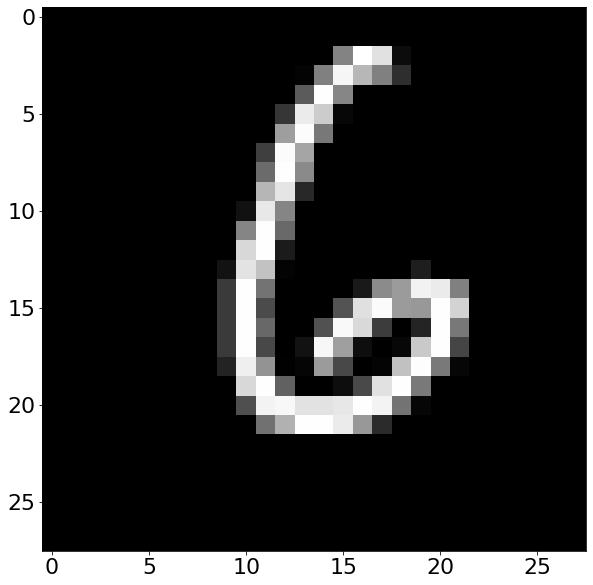

<Figure size 1440x720 with 0 Axes>

In [ ]:
# load mnist dataset of characters
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
plt.imshow(x_train[32],cmap = 'gray')

Text(0.5, 1.0, 'combined reconstruction from both direction')

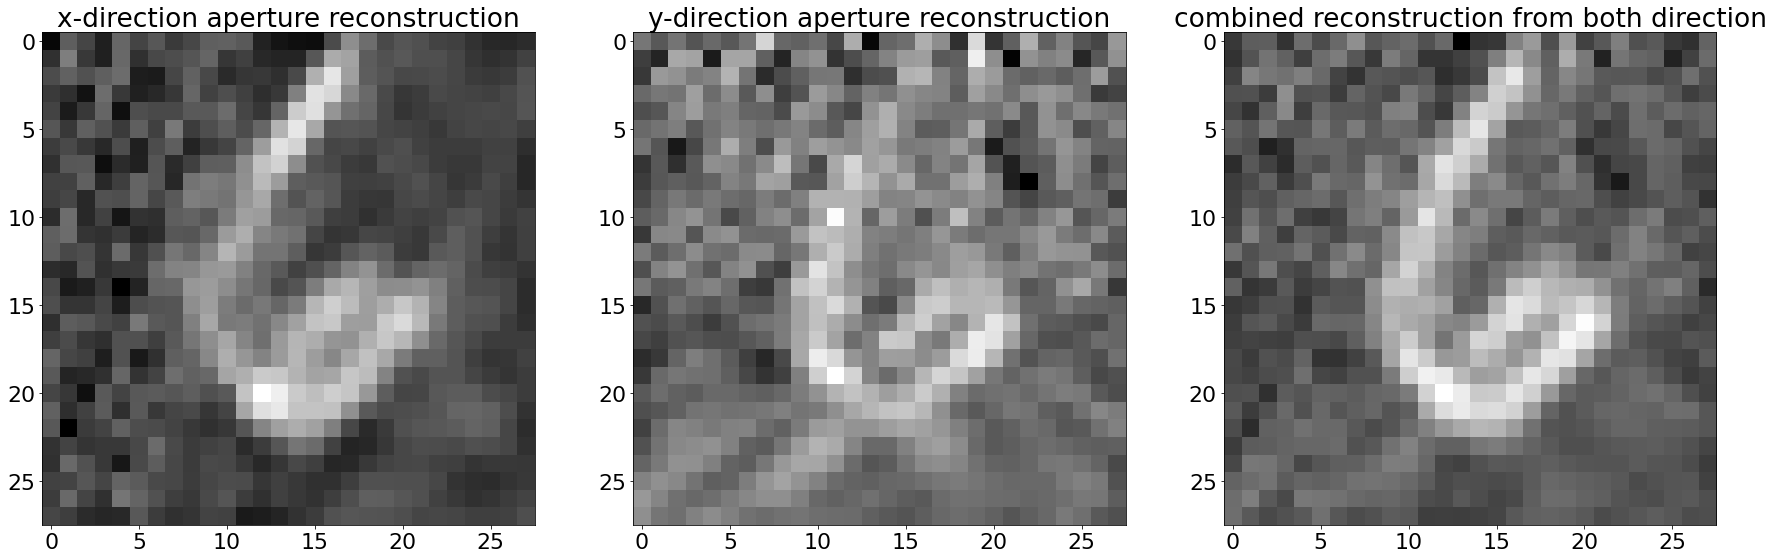

In [ ]:
# Plotting reconstruction from individual directions
recon_x = np.reshape(np.matmul(np.linalg.pinv(Hx),np.matmul(Hx,np.reshape(x_train[32],N**2))),(N,N))
recon_y = np.reshape(np.matmul(np.linalg.pinv(Hy),np.matmul(Hy,np.reshape(x_train[32],N**2))),(N,N))

# taking the average between the two reconstructions and then scaling the
# values of the image by the mean (there is probably a more sophisticated way
# to combine these two images, but this is what we are doing for now)
recon = (recon_x +recon_y) / 2
plt.imshow(recon / np.mean(recon))

plt.subplot(1,3,1)
plt.imshow(recon_x)
plt.title('x-direction aperture reconstruction')
plt.subplot(1,3,2)
plt.imshow(recon_y)
plt.title('y-direction aperture reconstruction')
plt.subplot(1,3,3)
plt.imshow(recon)
plt.title('combined reconstruction from both direction')

### Prepping the Denoising Model
For this case we will be utlizing the combined reconstruction as the input rather than the outputs from the two individual aperture cases.

100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (60000 of 60000) |##################| Elapsed Time: 0:00:09 Time:  0:00:09


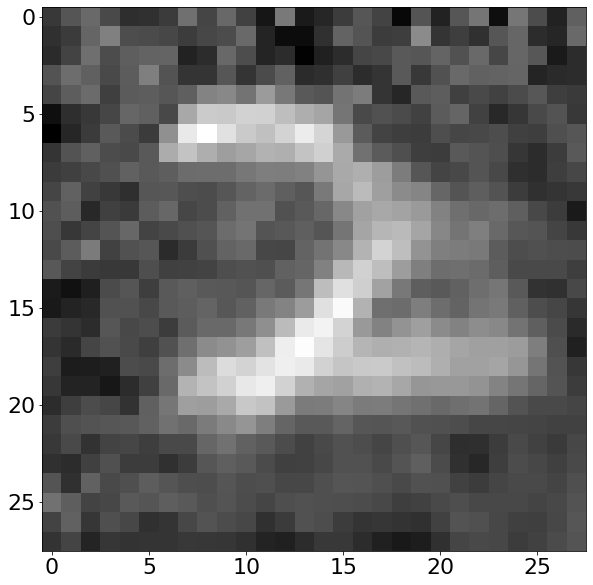

In [ ]:
g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))

pbar1 = ProgressBar()
for pop in pbar1(range(np.shape(x_test)[0])):
  g_test[pop,:,:]= (np.reshape(np.matmul(ph_x,np.matmul(Hx,np.reshape(x_test[pop],N**2))),(N,N)) + np.reshape(np.matmul(ph_y,np.matmul(Hy,np.reshape(x_test[pop],N**2))),(N,N))) / 2
  g_test[pop,:,:]=g_test[pop,:,:]/np.mean(g_test[pop,:,:])

pbar2 = ProgressBar()
for pop in pbar2(range(np.shape(x_train)[0])):
  g_train[pop,:,:]=(np.reshape(np.matmul(ph_x,np.matmul(Hx,np.reshape(x_train[pop],N**2))),(N,N)) + np.reshape(np.matmul(ph_y,np.matmul(Hy,np.reshape(x_train[pop],N**2))),(N,N))) / 2
  g_train[pop,:,:]=g_train[pop,:,:]/np.mean(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

plt.imshow(g_test[1932].reshape(N,N))

In [ ]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        16416     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 16)        4624

In [ ]:
# Training the model
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 5s 9ms/step - loss: 0.0139 - val_loss: 0.0061
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0035 - val_loss: 0.0033

### Results

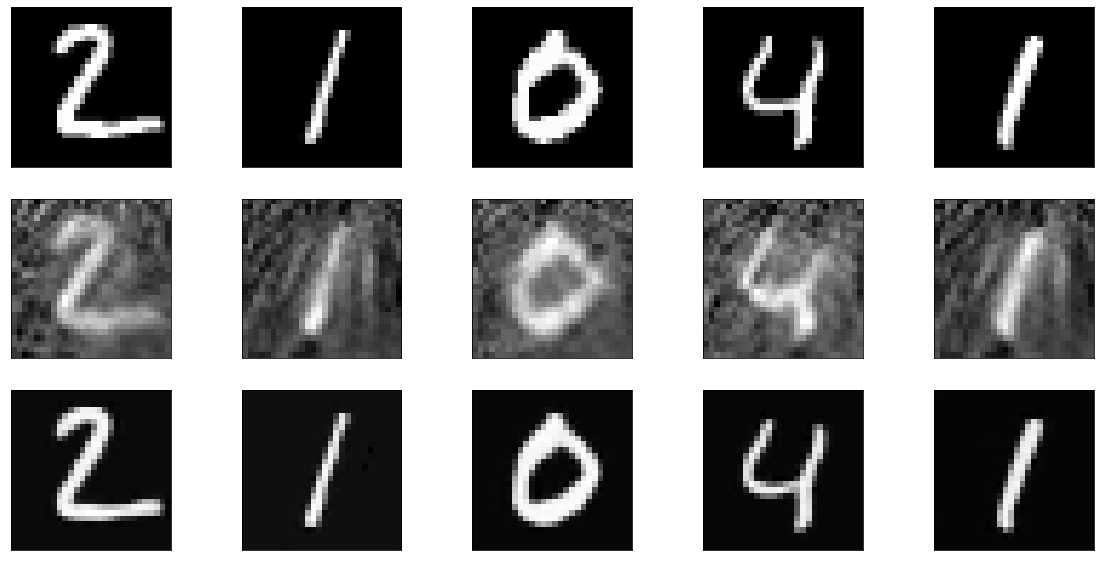

In [ ]:
# Plotting results from our reconstruction and denoising network
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

The average MSE over all test images = 
2.5596688838566215


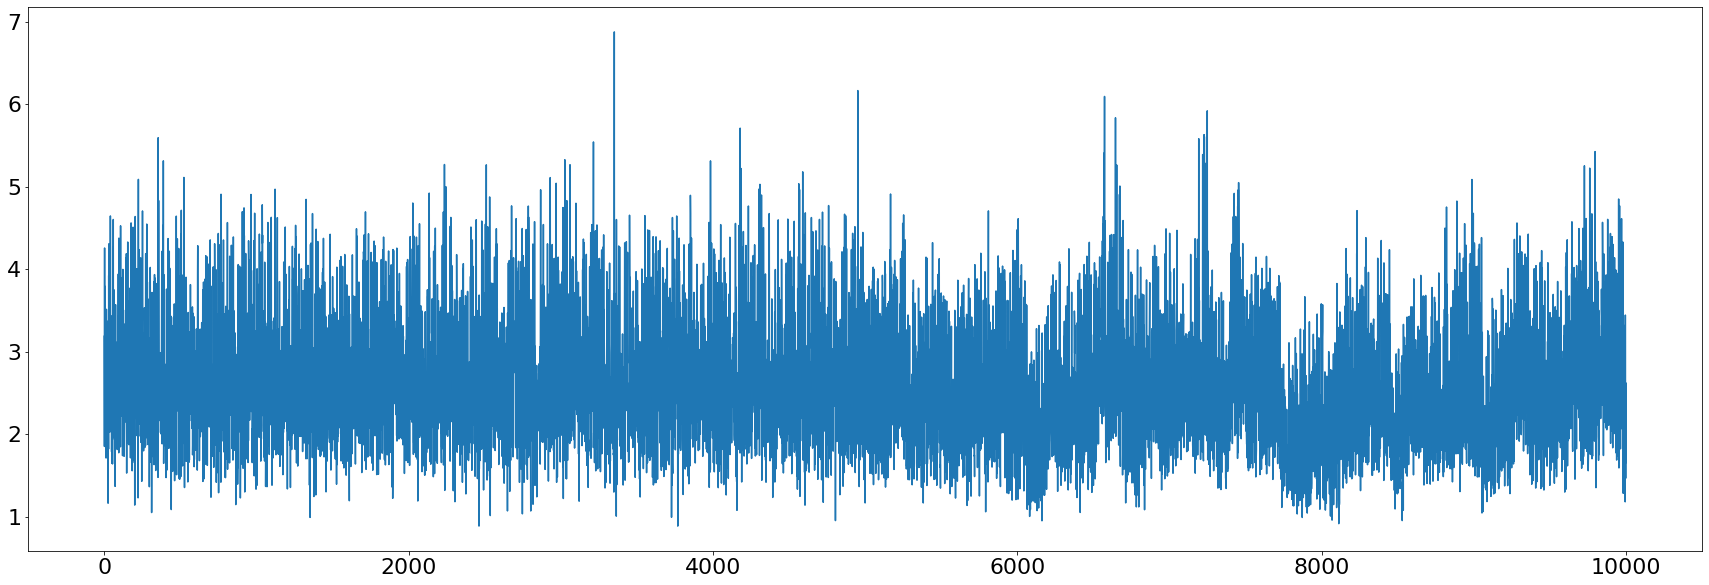

In [ ]:
# For fun, calculating MSE between the ground truth and 
# reconstructed/denoised images

MSE = np.zeros(np.shape(x_test)[0])
for pop in range(np.shape(x_test)[0]):
  MSE[pop] = np.square(np.subtract(x_test[pop,:,:,:],g_test[pop,:,:,:])).mean()

averageMSE = np.mean(MSE)

plt.plot(MSE)
print('The average MSE over all test images = ')
print(averageMSE)

### Discussion

As a first point here I would like to say that this was a very fun exercise. I think this one out of all of the others in this assignment helped to solidify the concepts of coded aperture imaging, tomography, and neural reconstruction/denoising - not only as a whole unit but the individual algorithms, as well. 

Overall, I can confidently say that the addition of a second 1D coded aperture increased the quality of the final reconstruction. Looking at the individual reconstructions side-by-side (apertures orthogonal to the x and also to the y direction) next to the combined reconstruction, we can see that the main feature in the image "sticks out" much better. In the example shown above in this exercise, the number 6 has sharper edges and an overall higher contrast compared to either of the individual reconstructions. Something to point out: in both of the x and y direction apertures, the reconstructed image contains a bit of blur along one edge or half of the image. When the two of these are combined, this effect is exasperated and appears to take up a larger portion of the image. Interstingly, though, this seems to mitigate or smooth some of the noise in those areas. I am curious to see and eventually investigate what the results would look like if we also implemented two additional coded apertures in the opposite directions? Have not thought into this too much yet conceptually, but would this be the initial step into coded aperture projection tomography, if you were to implement numerous apertures along several axes? 

Comparing the final output of this to the single axis reconstruction and denoised images from Dr. Brady's code, it appears that the additional projection allows for the recovery of more accurate object data. In the example's results, the number 4 is hardly distinguishable pre-denoising. But in this exercise after implementing the second aperture, the pre-denoising reconstructed image is much clearer, and the 4 is a bit more visible. Out of curiousity, I had plotted the mean square error between the ground truth images and the final reconstructed & denoised images. This plot is interesting for a few reasons. Firstly, it appears that as the network gets into the second half of the test images, the MSE values decrease in variation. It also seems that there are some underlying patterrns or clusters of images with approximately similar MSE - is this due to the nature of the network, the organization / processing order of images, or some other reason?